In [1]:
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import json

In [92]:
# this helps with scrolling df
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# My functions

In [3]:
def plot_histogram(df, variable, count = True):
    """
    Args:
        df: data frame with categoretical variable and label named as "label"
        column: string - name of column with categorical data
        count: True - returns count plot, False - kde plot
        
    Returns:
        prints histogram based on label split
    
    """
    plt.tight_layout() 
    plt.figure(figsize=(8,6))
    if count:
        sns.countplot(x=variable, hue="label", data=df, palette="hls")
        plt.title("Count of label vs size bins- "+variable,fontsize=20)
        plt.xlabel("Bin size",fontsize=15)
        plt.ylabel("Count",fontsize=15)
        plt.xticks(rotation=45)
        plt.legend(['non-malware','malware'],loc='upper right')
    else:
        sns.displot(x=variable, hue='label',data=df, kind = 'kde', fill = True)

    
    plt.show()
    
def chi_2(df, variable):
    
    cross_table = pd.crosstab(df['label'],df[variable])
    chi2, p, dof, ex = stats.chi2_contingency(cross_table) 
    alpha = 0.05
    

    print('chi_2 statistic: {:.2f}'.format(chi2))
    print('p_value: {:.2f}'.format(p))
    print("significant level", alpha)
    
    if p <=alpha:
        print('Reject H0, variables have dependency')
    else:
        print('Do not reject H0')
        
def plot_chi(df, variable, count = True):
    """
    Args: 
        df:
        variable:
        count: says if we have categorical variable
    Returns: 
    Chi2 table and hist plot
    """
    
    plot_histogram(df, variable, count)
    chi_2(df, variable)

In [4]:
# Ada's code but changed a little bit

def read_data(path, limiter):
    """
    Args:
        path: path to dataset in jsonl file format
        limiter: number of rows

    Returns:
        data: json dict, where every line is one sample as json
    """
    with open(path) as file:
        data = [json.loads(next(file)) for x in range(limiter)]
    return data


def transform_dll_imports(json_sample):
    """
    Args:
        json_sample: one sample of dataset

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    imports = sample["imports"]
    functions_dict = {}
    for key in imports.keys():
        functions = imports[key]
        functions_with_values = {key.lower() + "-" + f_name: True for f_name in functions}
        functions_dict.update(functions_with_values)
    return functions_dict


def transform_dict(json_dict):
    """
    Args:
        json_dict: json dict with nested key-value, where value is list

    Returns:
        functions_dict: dict with value as a key and default value True
    """
    result_dict = {}
    for key in json_dict.keys():
        keys = json_dict[key]
        values_with_default = {key.lower() + "-" + f_name: True for f_name in keys}
        result_dict.update(values_with_default)
    return result_dict


def transform_list(json_list):
    """
    Args:
        json_list: json list of values

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    result_dict = {}
    result_dict.update({i: True for i in json_list})
    return result_dict


def flatten_json(y, separator=''):
    """
    Args:
        y: json object
        separator: separator

    Returns:
        functions_dict: dict with flatten values
    """
    out = {}

    def flatten(x, name=separator):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Extract "sha256", "md5", "appeared", "label" and "avclass" columns to a flat form

def get_simple_column(sample, columns = ["sha256", "md5", "appeared", "label", "avclass"]):
    '''
    input:
        data: variable with dataset
        columns: list of names extracted columns
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
    simple_dict = {}
    simple_dict.update({column:sample[column] for column in columns})
    return simple_dict

# Extraction columns with list: "histogram", "byteentropy", "exports"

def get_simple_list_from_column(sample, columns = ["histogram", "byteentropy", "exports"]):

    '''
    input:
        data: variable with dataset
        columns: name of extracted columns (str)
    output:
        final_list: list of dicts, one list's element is a one sample of dataset
    '''
  
    dict_exports = {}
    dict_others = {}
    dict_final = {}

    for column in columns:
        if column == "exports":
            dict_exports.update({column+"_"+str(v).lower():True for v in sample[column]})
        else:
            dict_others.update({column+"_"+str(i):n for i, n in enumerate(sample[column])})             
                
    dict_final.update(dict_others)
    dict_final.update(dict_exports)
               
    return dict_final


# Extraction IMPORTS, GENERAL and STRINGS columns

def get_features_from_dict_column(sample, columns = "imports"):
    '''
    input:
            data
            columns
    output:
            functions_with_valuex
    '''
    dict_final = {}
    temp1 = {}
    temp2 = {}
    temp3 = {}

    feature = sample[columns]
    for key in feature.keys():
        content = feature[key]
        if (isinstance(content, list) and len(content)!=0):
            if not isinstance(content[0], str):
                temp1.update({columns +"_"+key.lower() + "-" + str(i):cont for i, cont in enumerate(content)})
            else:
                temp2.update({columns +"_"+ key.lower() + "-" + str(cont).lower():True for cont in content})
        else:
            temp3.update({columns+"_"+key:content})

    dict_final.update(temp1)   
    dict_final.update(temp2) 
    dict_final.update(temp3) 
    return dict_final

# Extraction HEADER column

def get_features_from_header(sample):
    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''    
    headers = sample["header"]
    dict_lists = {}
    dict_others = {}
    dict_final = {}

    for h in headers.keys():   
        temp = headers[h]      
        for k in temp.keys():  

#             if isinstance(temp[k], list):
#                 dict_lists.update({"header_"+h.lower()+"_"+k.lower()+"_"+str(t).lower():True for t in temp[k]}) 
#             else:
            dict_others.update({"header_"+h.lower()+"_"+k.lower():temp[k]})

    dict_final.update(dict_lists)    
    dict_final.update(dict_others)
    return dict_final


# Extraction Section column

def get_features_from_section(sample):

    '''
    input:
        data: data
    output:
        list_final: list of dicts
    '''  
    section_entry = sample['section']['entry']    # .text
    section_sections = sample['section']['sections']
    dict_others_sections = {}
    dict_final = {}
    
    simple_dict = {}
    simple_dict.update({'section_entry':section_entry})
    
    for part in section_sections:
        name = part['name']
        for position in ['size', 'entropy', 'vsize', 'props']:
            dict_others_sections.update({"section_"+"sections_"+name.lower()+"_"+position:part[position]})
    
    dict_final.update(simple_dict)
    dict_final.update(dict_others_sections)
    return dict_final


# Extraction DATADIRECTORIES column

def get_features_from_datadirectories(sample):
    '''
    input:
        data: data
    output:
        sum_others_datadir: list of dicts
    '''  

    dict_others_datadir = {}
    datadir = sample["datadirectories"]

    for element in datadir:
        element_name = element['name']
        for position in ['size', 'virtual_address']:
            dict_others_datadir.update({"datadirectories_"+element_name+"_"+position:element[position]})
    return dict_others_datadir



def write_csv(csv_file_path, sample_list):
    """
    Args:
        csv_file_path: destination path of csv file
        sample_list: list of dicts 
    """
    all_keys = set().union(*(d.keys() for d in flatten_dataset))    

    try:
        with open(csv_file_path, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=all_keys)
            writer.writeheader()
            for data in flatten_dataset:
                writer.writerow(data)
    except IOError:
        print("I/O error")



In [5]:
# 1. read datas
data_path = 'sample_data_6k.jsonl'
data = read_data(data_path, limiter=6000)
# 2. iterate over dataset
flatten_dataset = []
for sample in data:
    # version 1 dummy way
    # flat = flatten_json(sample)
    # flatten_dataset.append(flat)
    # collect transformed values for each sample

    # version 2
    transformed = {}

    transformed.update(get_simple_column(sample))
#     transformed.update(get_simple_list_from_column(sample))
#     transformed.update(get_features_from_dict_column(sample, columns = "strings"))
#     transformed.update(get_features_from_dict_column(sample, columns = "general"))
#     transformed.update(get_features_from_dict_column(sample, columns = "imports"))
    transformed.update(get_features_from_header(sample))
    transformed.update(get_features_from_section(sample))
#     transformed.update(get_features_from_datadirectories(sample))


    # here we fill with transform data
    flatten_dataset.append(transformed)




In [6]:
# change all transformed dataset to dataframe object

df_flat = pd.DataFrame(flatten_dataset)



### Sampling for having same number of classess

In [7]:
# sample data with label == 0 to have the same number of class

non_mal_flat = df_flat[df_flat.label==0].sample(1932,random_state=3)

In [8]:
# select data with label == 1 

df_r = pd.concat([df_flat[df_flat.label==1], non_mal_flat]).reset_index()

### Drop non relevant columns for analysis

In [9]:
# drop non relevant columns (for my analysis)

df_r.drop(['index','sha256','md5','appeared','avclass'], axis =1, inplace =True)

In [10]:
# drop non relevant columns size & vsize as they are non relevant from 

df_r.drop(df_r.columns[df_r.columns.str.contains('_size')],axis=1, inplace=True)
df_r.drop(df_r.columns[df_r.columns.str.contains('_vsize')],axis=1, inplace=True)

In [11]:
# unique entry sections

df_r['section_entry'].unique()

array(['.code', '.text', 'CODE', 'UPX0', '', '.AD8Te', '7744', '.',
       '.rsrc', '.neolit', '   ', '2sJpMTKE', '-/\x0c', '.MPRESS1',
       '.vmp0', '.crt1', 'tWg\x12K4Qr', '.crt', '.zxdae', '.flat',
       '.rdata', '.adata', '.indata', 'ATU0', 'XbWcczqo', '8sj(dsj2',
       '.HEYeA', '.itext', '\x03\tO@fw\x062', ';\x11\x051,Neu', '.data',
       '.CRT2', '.zcode', '.rodata', 'Ei<\x04\x0eVLm', 'O\x153t`yC`',
       "+\x05eQkb'+", '\x1a=\n', '_TEXT', 'AUTO', 'EPE0', '3', '.nsp0',
       '.text\x01', '.textbss', '.pjz', '{P\x15A?}\x10!', '.xdata',
       'code', '/89', '.reloc', '.bss', '.orpc'], dtype=object)

## Column: Sections

### Sections - Creating new features

In [12]:
# create list of standard 
# source: https://keystrokes2016.wordpress.com/2016/06/03/pe-file-structure-sections/

standard_entries = ['.text', '.bss', '.rdata', '.data', '.rsrc', '.edata', '.idata', '.pdata', '.debug']

In [13]:
# 1 - entry is in standard entry, 0 - entry is not standard

df_r['section_has_non_standard_entry'] = np.where(df_r['section_entry'].isin(standard_entries),0,1)

In [14]:
# count number of sections 

df_r['section_cnt'] = df_r[df_r.columns[df_r.columns.str.contains('_entropy')]].apply(lambda x: sum(x>=0),axis=1)

In [15]:
# count sections which contain high entropy (>6)

df_r['section_high_entropy_cnt'] = df_r[df_r.columns[df_r.columns.str.contains('_entropy')]].apply(lambda x: sum(x>=6),axis=1)

In [16]:
# create new column: section_high_entropy ratio

df_r['section_high_entropy_ratio'] = df_r['section_high_entropy_cnt'] /df_r['section_cnt']

In [17]:
# create new column: max section entropy

df_r['section_entropy_max'] = df_r[df_r.columns[df_r.columns.str.contains('_entropy')]].max(axis=1)


In [18]:
def get_non_standard_section_ratio(row, good_sections = standard_entries):
    """
    Functions returns ratio of non standard sections in sections field. This function is used in apply 
    Args:
        row: row of df
        good_sections: list of section names considered as normal/standard
    Return: 
        ratio of #non standard sections/ # all sections
    
    """
    
    labels = row[~np.isnan(row)].index
    
    list_of_names = [k.replace('section_sections_',"").replace('_entropy',"") for k in labels]
    
    proper_filter = [lab for lab in list_of_names if lab not in good_sections]
    
    if len(list_of_names) == 0:
        return np.NaN
    else:
        return len(proper_filter) /len(list_of_names)
    

In [19]:
df_r['section_has_non_standard_sections_ratio'] = df_r[df_r.columns[df_r.columns.str.endswith('_entropy')]].apply(lambda x: get_non_standard_section_ratio(x,standard_entries),axis=1)

In [20]:
df_r.shape

(3864, 1222)

### Conclusion: 

6 new columns have been created:
- [binary] 'section_has_non_standard_entry' - 1 if entry is not standard else 0
- [int] 'section_cnt' - count of sections in PE file
- [int] 'section_high_entropy_cnt'- count of sections with high entropy (>6)
- [float] 'section_high_entropy_ratio' - 'section_high_entropy_cnt'/ 'section_cnt'
- [float] 'section_entropy_max' - maximum entropy across sections
- [float] 'section_has_non_standard_sections_ratio' - #non standard sections/ #all sections in PE file


4 Fetures selected for further analysis:
- [binary] 'section_has_non_standard_entry'
- [float] 'section_high_entropy_ratio'
- [float] 'section_entropy_max'
- [float] 'section_has_non_standard_sections_ratio'



In [21]:
section_columns = ['section_has_non_standard_entry', 'section_high_entropy_ratio','section_entropy_max', 'section_has_non_standard_sections_ratio']
columns = section_columns

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

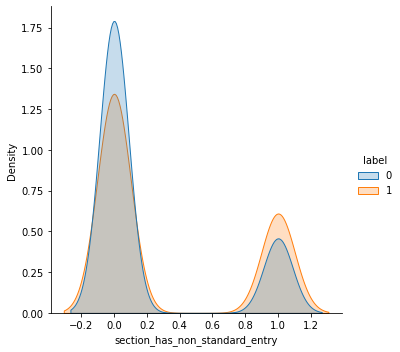

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

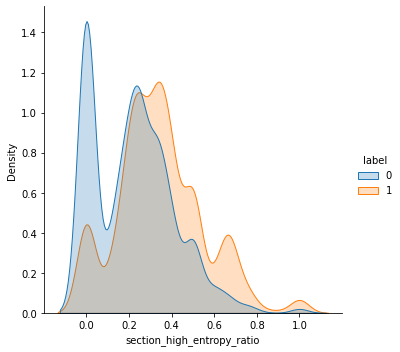

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

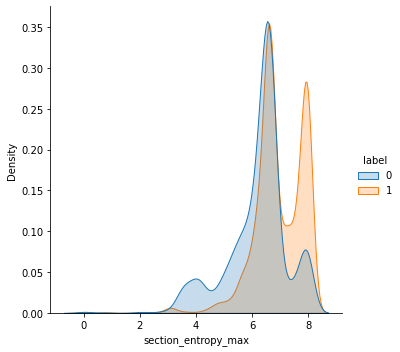

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

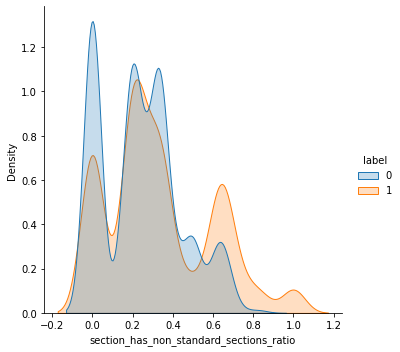

In [22]:
for col in columns:
    plot_histogram(df_r, col, False)


In [23]:
df_r[columns].corr()

,section_has_non_standard_entry,section_high_entropy_ratio,section_entropy_max,section_has_non_standard_sections_ratio
section_has_non_standard_entry,1.000000,-0.000090,-0.034425,0.561251
section_high_entropy_ratio,-0.000090,1.000000,0.721616,0.078541
section_entropy_max,-0.034425,0.721616,1.000000,0.226061
section_has_non_standard_sections_ratio,0.561251,0.078541,0.226061,1.000000


### Conclusions: 
- section_has_non_standard_entry - this is binary value, we will calculate seperate test
- section_high_entropy_ratio is corelated with section_entropy_max, let's use also different techniques to select apriopriate column
- distributions looks good, groups are seperated




In [24]:
from scipy import stats

#### is section_has_non_standard_entry  dependent with other continuus variables?

In [25]:
for col in columns:
    print(stats.pointbiserialr(df_r[df_r['section_cnt']!=0][col],df_r[df_r['section_cnt']!=0]['section_has_non_standard_entry']))

PointbiserialrResult(correlation=0.999999999999991, pvalue=0.0)
PointbiserialrResult(correlation=-8.980756125993064e-05, pvalue=0.9955478222770259)
PointbiserialrResult(correlation=-0.031873340300691486, pvalue=0.047603943155238145)
PointbiserialrResult(correlation=0.5612513446096893, pvalue=1.4324e-319)


##### Looks. that they are quite independent, TBC
- section_high_entropy_ratio: don't know
- 'section_entropy_max': not corelated
- 'section_has_non_standard_sections_ratio': potentialy corelated

## Column: Header

In [26]:
df_r[df_r.columns[df_r.columns.str.contains('coff')]]

,header_coff_timestamp,header_coff_machine,header_coff_characteristics
0,1301832471,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."
1,1511340343,I386,"[CHARA_32BIT_MACHINE, EXECUTABLE_IMAGE]"
2,1510798547,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."
3,1514434785,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."
4,708992537,I386,"[CHARA_32BIT_MACHINE, BYTES_REVERSED_LO, EXECU..."
...,...,...,...
3859,982600987,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."
3860,1005228158,I386,"[LOCAL_SYMS_STRIPPED, CHARA_32BIT_MACHINE, EXE..."
3861,1238606545,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."
3862,1074714471,I386,"[CHARA_32BIT_MACHINE, RELOCS_STRIPPED, EXECUTA..."


In [27]:
drop = ['header_coff_characteristics','header_optional_dll_characteristics']

In [28]:
encode = ['header_coff_machine','header_optional_subsystem','header_optional_magic']

### Variable: 'header_coff_machine' & 'header_coff_timestamp

<Figure size 432x288 with 0 Axes>

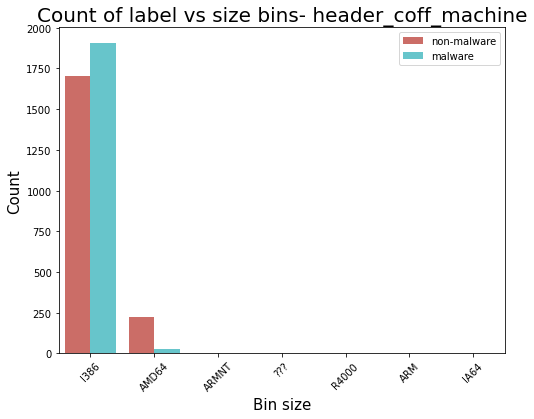

chi_2 statistic: 180.16
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [29]:
plot_chi(df_r,'header_coff_machine')

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

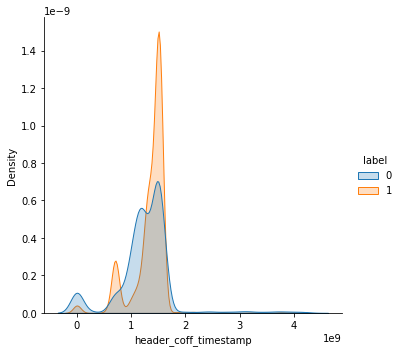

In [30]:
plot_histogram(df_r,'header_coff_timestamp', False)

In [31]:
stats.pointbiserialr(df_r['label'],df_r['header_coff_timestamp'])

PointbiserialrResult(correlation=0.09014631079273476, pvalue=1.9860704949640037e-08)

#### Conclusions: coff_machine is corelated with label, coff_timestamp is not corelated with label, to be confirmed with SME

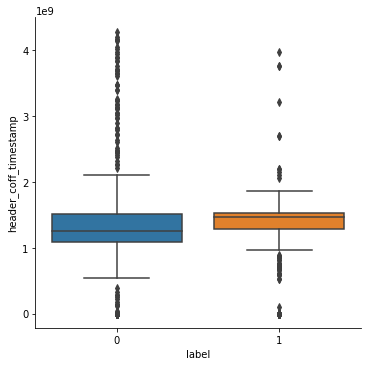

In [124]:
sns.catplot(x="label", y="header_coff_timestamp", data=df_r,kind="box")

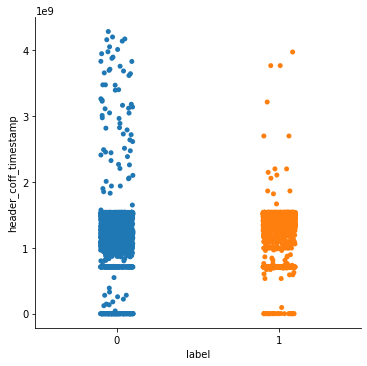

In [125]:
sns.catplot(x="label", y="header_coff_timestamp", data=df_r)

### Variables: Optional

In [32]:
df_r[df_r.columns[df_r.columns.str.contains('optional')]]

,header_optional_subsystem,header_optional_dll_characteristics,header_optional_magic,header_optional_major_image_version,header_optional_minor_image_version,header_optional_major_linker_version,header_optional_minor_linker_version,header_optional_major_operating_system_version,header_optional_minor_operating_system_version,header_optional_major_subsystem_version,header_optional_minor_subsystem_version
0,WINDOWS_GUI,[],PE32,0,0,2,50,4,0,4,0
1,WINDOWS_GUI,"[DYNAMIC_BASE, NX_COMPAT, TERMINAL_SERVER_AWARE]",PE32,0,0,14,11,5,1,5,1
2,WINDOWS_GUI,"[NX_COMPAT, TERMINAL_SERVER_AWARE]",PE32,0,0,10,0,5,1,5,1
3,WINDOWS_GUI,[],PE32,0,0,5,12,4,0,4,0
4,WINDOWS_GUI,[],PE32,0,0,2,25,4,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
3859,WINDOWS_GUI,[],PE32,0,0,6,0,4,0,4,0
3860,WINDOWS_GUI,[],PE32,0,0,6,0,4,0,4,0
3861,WINDOWS_GUI,[TERMINAL_SERVER_AWARE],PE32,0,0,9,0,5,0,5,0
3862,WINDOWS_GUI,[],PE32,0,0,6,0,4,0,4,0


<Figure size 432x288 with 0 Axes>

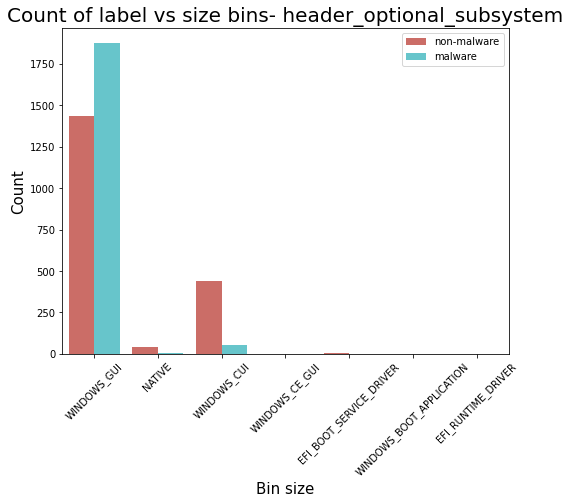

chi_2 statistic: 407.33
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [33]:
plot_chi(df_r,'header_optional_subsystem')

<Figure size 432x288 with 0 Axes>

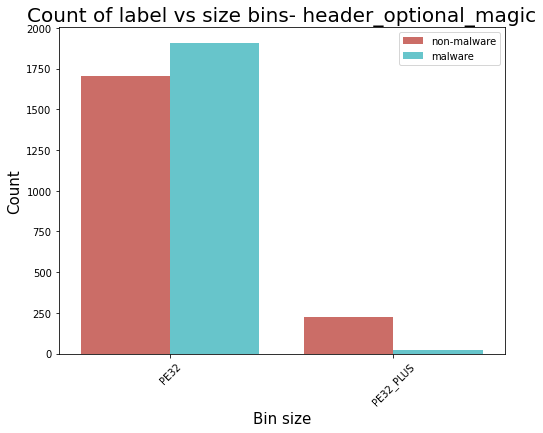

chi_2 statistic: 173.86
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [34]:
plot_chi(df_r, 'header_optional_magic')

<Figure size 432x288 with 0 Axes>

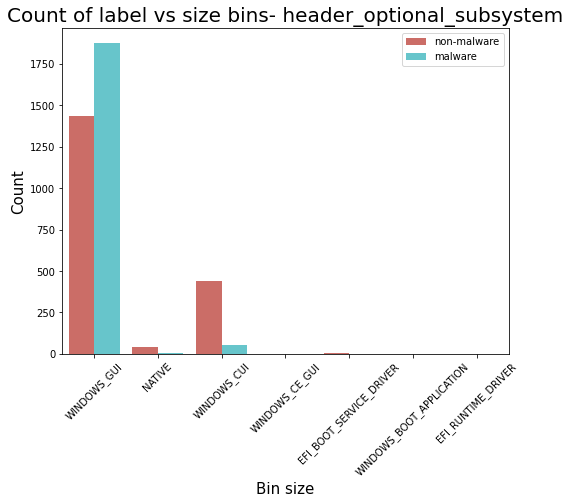

chi_2 statistic: 407.33
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

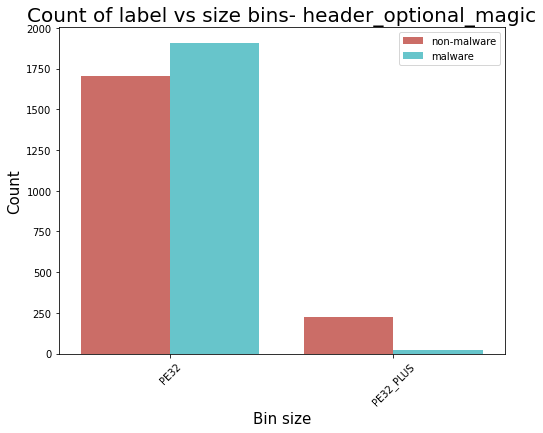

chi_2 statistic: 173.86
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

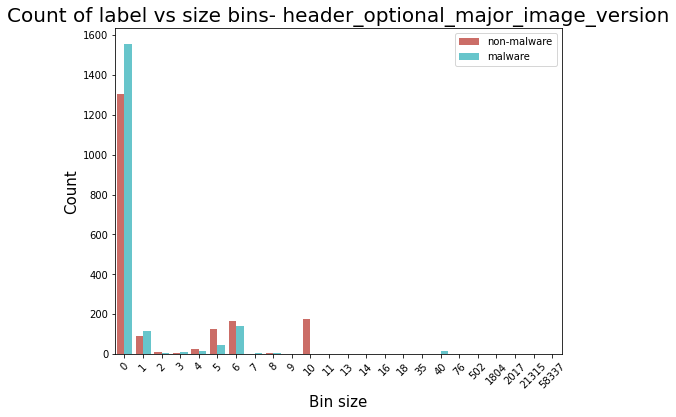

chi_2 statistic: 280.25
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

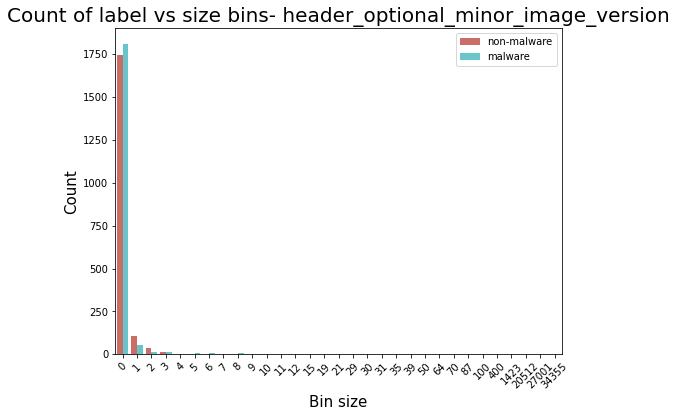

chi_2 statistic: 59.81
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

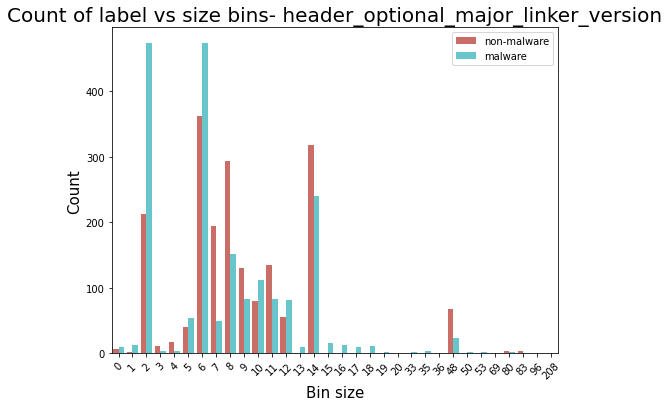

chi_2 statistic: 414.20
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

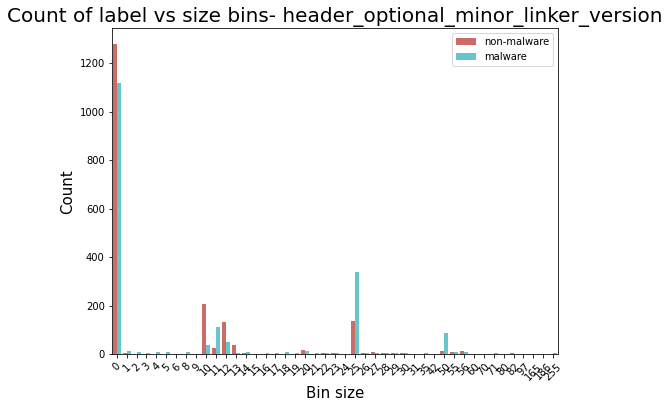

chi_2 statistic: 478.85
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

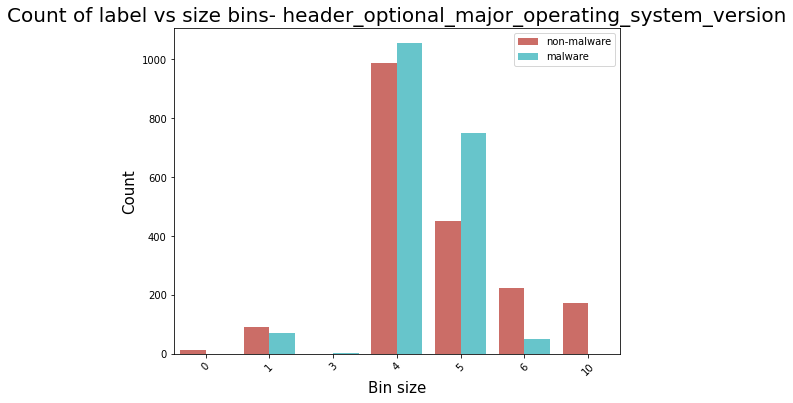

chi_2 statistic: 371.34
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

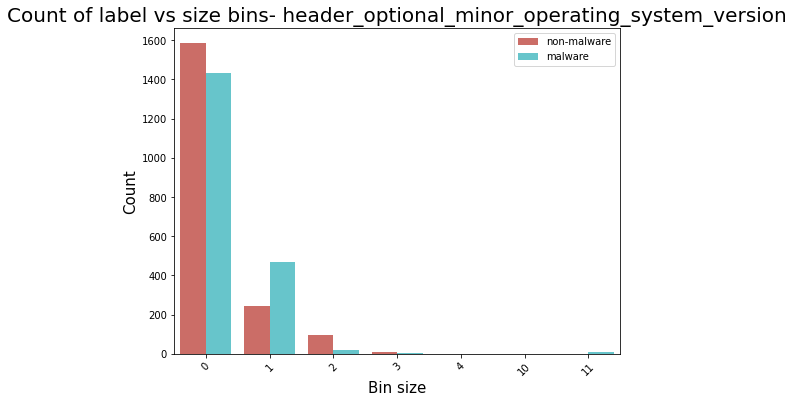

chi_2 statistic: 141.77
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

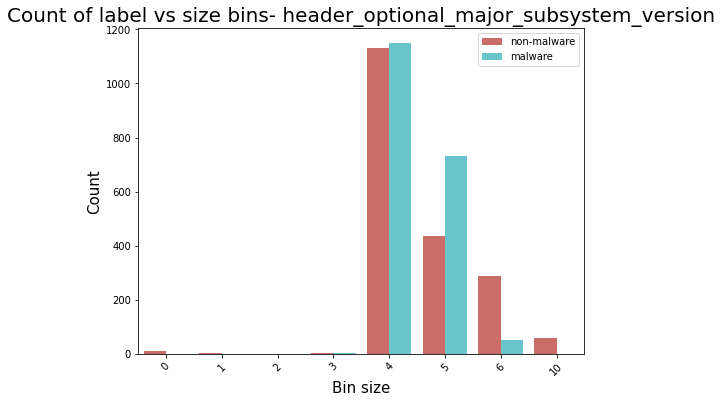

chi_2 statistic: 312.99
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


<Figure size 432x288 with 0 Axes>

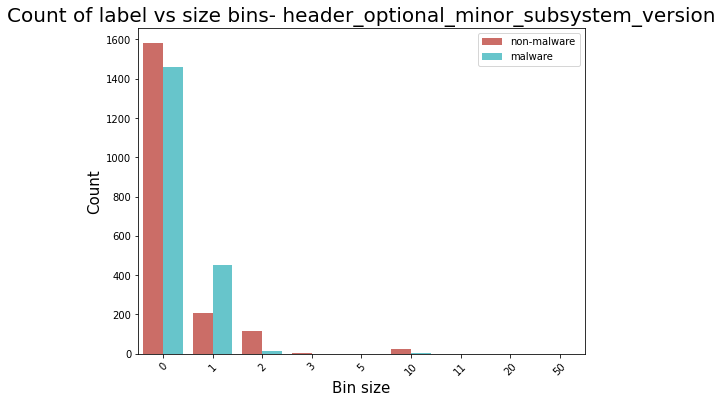

chi_2 statistic: 188.03
p_value: 0.00
significant level 0.05
Reject H0, variables have dependency


In [35]:
for col in df_r.columns[df_r.columns.str.contains('optional')]:
    if col != 'header_optional_dll_characteristics':
        plot_chi(df_r, col)
    
    

In [45]:
corr = df_r[['header_optional_major_image_version',
       'header_optional_minor_image_version',
       'header_optional_major_linker_version',
       'header_optional_minor_linker_version',
       'header_optional_major_operating_system_version',
       'header_optional_minor_operating_system_version',
       'header_optional_major_subsystem_version',
       'header_optional_minor_subsystem_version']]

,header_optional_major_image_version,header_optional_minor_image_version,header_optional_major_linker_version,header_optional_minor_linker_version,header_optional_major_operating_system_version,header_optional_minor_operating_system_version,header_optional_major_subsystem_version,header_optional_minor_subsystem_version
header_optional_major_image_version,1.000000,0.848727,NaN,NaN,NaN,NaN,NaN,NaN
header_optional_minor_image_version,0.848727,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
header_optional_major_linker_version,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
header_optional_minor_linker_version,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
header_optional_major_operating_system_version,NaN,NaN,NaN,NaN,1.000000,NaN,0.748724,NaN
header_optional_minor_operating_system_version,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
header_optional_major_subsystem_version,NaN,NaN,NaN,NaN,0.748724,NaN,1.000000,NaN
header_optional_minor_subsystem_version,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### Conclusion: All optional columns are corelated with label

### Summary

In [136]:
drop = ['header_coff_characteristics','header_optional_dll_characteristics','header_coff_timestamp']

In [138]:
encode = ['header_coff_machine','header_optional_subsystem','header_optional_magic']

In [139]:
take = df_r.columns[df_r.columns.str.startswith('header_')]

In [63]:
take

Index(['header_coff_timestamp', 'header_coff_machine',
       'header_coff_characteristics', 'header_optional_subsystem',
       'header_optional_dll_characteristics', 'header_optional_magic',
       'header_optional_major_image_version',
       'header_optional_minor_image_version',
       'header_optional_major_linker_version',
       'header_optional_minor_linker_version',
       'header_optional_major_operating_system_version',
       'header_optional_minor_operating_system_version',
       'header_optional_major_subsystem_version',
       'header_optional_minor_subsystem_version'],
      dtype='object')

In [140]:
take_filtered = [t for t in take if t not in drop]

In [65]:
take_filtered

['header_coff_timestamp',
 'header_coff_machine',
 'header_optional_subsystem',
 'header_optional_magic',
 'header_optional_major_image_version',
 'header_optional_minor_image_version',
 'header_optional_major_linker_version',
 'header_optional_minor_linker_version',
 'header_optional_major_operating_system_version',
 'header_optional_minor_operating_system_version',
 'header_optional_major_subsystem_version',
 'header_optional_minor_subsystem_version']

In [141]:
target = ['label']

In [142]:
all_columns = section_columns + take_filtered + target

In [143]:
len(all_columns)

16

### Select columns for further analysis

In [152]:
df_selected = df_r[all_columns].copy()

In [153]:
# drop NA

df_selected.dropna(inplace = True)

In [107]:
df_selected.head()

,section_has_non_standard_entry,section_high_entropy_ratio,section_entropy_max,section_has_non_standard_sections_ratio,header_coff_timestamp,header_coff_machine,header_optional_subsystem,header_optional_magic,header_optional_major_image_version,header_optional_minor_image_version,header_optional_major_linker_version,header_optional_minor_linker_version,header_optional_major_operating_system_version,header_optional_minor_operating_system_version,header_optional_major_subsystem_version,header_optional_minor_subsystem_version,label
0,1,0.20,6.19,0.20,1301832471,I386,WINDOWS_GUI,PE32,0,0,2,50,4,0,4,0,1
1,0,0.40,6.64,0.20,1511340343,I386,WINDOWS_GUI,PE32,0,0,14,11,5,1,5,1,1
2,0,0.33,6.05,0.00,1510798547,I386,WINDOWS_GUI,PE32,0,0,10,0,5,1,5,1,1
3,0,1.00,7.85,0.00,1514434785,I386,WINDOWS_GUI,PE32,0,0,5,12,4,0,4,0,1
4,1,0.25,6.90,0.62,708992537,I386,WINDOWS_GUI,PE32,0,0,2,25,4,0,4,0,1


In [83]:
df_selected.describe(include = 'all')

,section_has_non_standard_entry,section_high_entropy_ratio,section_entropy_max,section_has_non_standard_sections_ratio,header_coff_timestamp,header_coff_machine,header_optional_subsystem,header_optional_magic,header_optional_major_image_version,header_optional_minor_image_version,header_optional_major_linker_version,header_optional_minor_linker_version,header_optional_major_operating_system_version,header_optional_minor_operating_system_version,header_optional_major_subsystem_version,header_optional_minor_subsystem_version,label
count,3863.000000,3863.000000,3863.000000,3863.000000,3.863000e+03,3863,3863,3863,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000
unique,NaN,NaN,NaN,NaN,NaN,7,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,I386,WINDOWS_GUI,PE32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3608,3310,3612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.257572,0.281103,6.560379,0.285399,1.295858e+09,NaN,NaN,NaN,29.067823,27.320994,9.007248,8.276469,4.581413,0.278799,4.558115,0.343774,0.500129
std,0.437354,0.206735,1.053378,0.235684,4.416484e+08,NaN,NaN,NaN,1057.236733,843.862921,8.951793,15.417097,1.510720,0.731891,0.972792,1.344712,0.500065
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.142857,6.191553,0.142857,1.162456e+09,NaN,NaN,NaN,0.000000,0.000000,6.000000,0.000000,4.000000,0.000000,4.000000,0.000000,0.000000
50%,0.000000,0.250000,6.610926,0.250000,1.400764e+09,NaN,NaN,NaN,0.000000,0.000000,8.000000,0.000000,4.000000,0.000000,4.000000,0.000000,1.000000
75%,1.000000,0.400000,7.244529,0.375000,1.518165e+09,NaN,NaN,NaN,1.000000,0.000000,11.000000,12.000000,5.000000,0.000000,5.000000,0.000000,1.000000


### Encoding

In [154]:
from sklearn.preprocessing import OrdinalEncoder

In [155]:
ord_enc = OrdinalEncoder()
df_selected[encode] = ord_enc.fit_transform(df_selected[encode])


In [156]:
df_selected[encode].head()

,header_coff_machine,header_optional_subsystem,header_optional_magic
0,4.00,6.00,0.00
1,4.00,6.00,0.00
2,4.00,6.00,0.00
3,4.00,6.00,0.00
4,4.00,6.00,0.00


In [90]:
ord_enc.categories_

[array(['???', 'AMD64', 'ARM', 'ARMNT', 'I386', 'IA64', 'R4000'],
       dtype=object),
 array(['EFI_BOOT_SERVICE_DRIVER', 'EFI_RUNTIME_DRIVER', 'NATIVE',
        'WINDOWS_BOOT_APPLICATION', 'WINDOWS_CE_GUI', 'WINDOWS_CUI',
        'WINDOWS_GUI'], dtype=object),
 array(['PE32', 'PE32_PLUS'], dtype=object)]

section_has_non_standard_entry                                    0.19
section_high_entropy_ratio                                        0.04
section_entropy_max                                               1.11
section_has_non_standard_sections_ratio                           0.06
header_coff_timestamp                            195053305902354496.00
header_coff_machine                                               0.55
header_optional_subsystem                                         0.37
header_optional_magic                                             0.06
header_optional_major_image_version                         1117749.51
header_optional_minor_image_version                          712104.63
header_optional_major_linker_version                             80.13
header_optional_minor_linker_version                            237.69
header_optional_major_operating_system_version                    2.28
header_optional_minor_operating_system_version                    0.54
header

### Scaling

In [157]:
from sklearn import preprocessing

In [158]:
df_selected.describe()

,section_has_non_standard_entry,section_high_entropy_ratio,section_entropy_max,section_has_non_standard_sections_ratio,header_coff_machine,header_optional_subsystem,header_optional_magic,header_optional_major_image_version,header_optional_minor_image_version,header_optional_major_linker_version,header_optional_minor_linker_version,header_optional_major_operating_system_version,header_optional_minor_operating_system_version,header_optional_major_subsystem_version,header_optional_minor_subsystem_version,label
count,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00,3863.00
mean,0.26,0.28,6.56,0.29,3.81,5.81,0.06,29.07,27.32,9.01,8.28,4.58,0.28,4.56,0.34,0.50
std,0.44,0.21,1.05,0.24,0.74,0.61,0.25,1057.24,843.86,8.95,15.42,1.51,0.73,0.97,1.34,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.14,6.19,0.14,4.00,6.00,0.00,0.00,0.00,6.00,0.00,4.00,0.00,4.00,0.00,0.00
50%,0.00,0.25,6.61,0.25,4.00,6.00,0.00,0.00,0.00,8.00,0.00,4.00,0.00,4.00,0.00,1.00
75%,1.00,0.40,7.24,0.38,4.00,6.00,0.00,1.00,0.00,11.00,12.00,5.00,0.00,5.00,0.00,1.00
max,1.00,1.00,8.00,1.00,6.00,6.00,1.00,58337.00,34355.00,208.00,255.00,10.00,11.00,10.00,50.00,1.00


In [159]:
to_scale = ['header_optional_major_image_version',
'header_optional_minor_image_version',                          
'header_optional_major_linker_version',                 
'header_optional_minor_linker_version']

In [160]:
for c in to_scale:
    df_selected[c + '_scaled'] = preprocessing.scale(df_selected[c])

In [161]:
df_selected.var()

section_has_non_standard_entry                         0.19
section_high_entropy_ratio                             0.04
section_entropy_max                                    1.11
section_has_non_standard_sections_ratio                0.06
header_coff_machine                                    0.55
header_optional_subsystem                              0.37
header_optional_magic                                  0.06
header_optional_major_image_version              1117749.51
header_optional_minor_image_version               712104.63
header_optional_major_linker_version                  80.13
header_optional_minor_linker_version                 237.69
header_optional_major_operating_system_version         2.28
header_optional_minor_operating_system_version         0.54
header_optional_major_subsystem_version                0.95
header_optional_minor_subsystem_version                1.81
label                                                  0.25
header_optional_major_image_version_scal

In [163]:
df_selected.drop(to_scale, axis = 1, inplace = True)

In [164]:
X = df_selected.drop('label', axis = 1)

In [165]:
y = df_selected['label']

In [169]:
correlation = X.corr()

<AxesSubplot:>

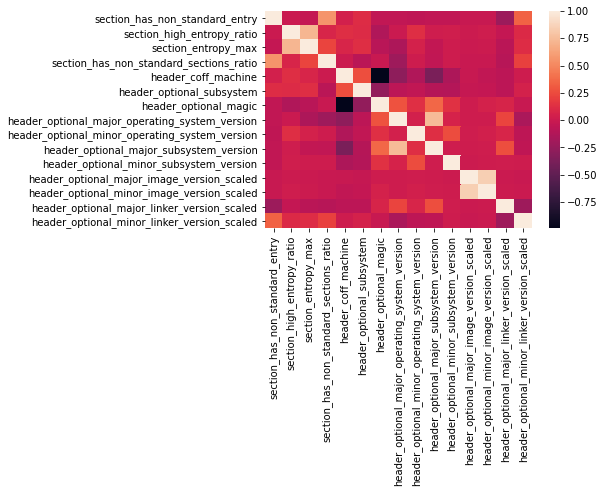

In [170]:
sns.heatmap(correlation)

### Feature selection

In [177]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [267]:
kbest = SelectKBest(f_classif, K=5)



TypeError: __init__() got an unexpected keyword argument 'K'

In [178]:
kbest.fit(X,y)

SelectKBest()

In [180]:
kbest.scores_

array([ 61.03989355, 394.39343284, 531.90582574, 143.21485021,
       182.52896947, 272.57703055, 183.97750392, 106.62766342,
         8.5292233 ,  68.63016916,   7.87582067,   2.70142694,
         3.96386248,  29.44421408,  83.88891866])

In [214]:
labels = X.columns

In [215]:
values = kbest.scores_

In [212]:
len(values)

15

In [213]:
values

array([ 61.03989355, 394.39343284, 531.90582574, 143.21485021,
       182.52896947, 272.57703055, 183.97750392, 106.62766342,
         8.5292233 ,  68.63016916,   7.87582067,   2.70142694,
         3.96386248,  29.44421408,  83.88891866])

In [ ]:
kbest

In [229]:
scores = pd.DataFrame(values, index=labels, columns = ['col'])

<AxesSubplot:>

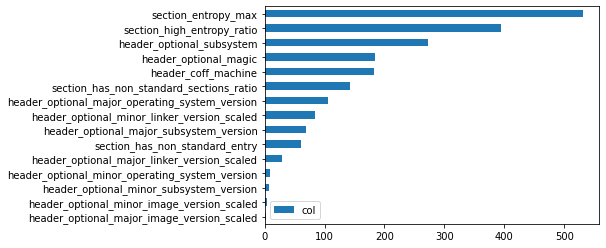

In [235]:
scores.sort_values('col',ascending = True).plot(kind='barh')

## Model

In [259]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

In [268]:
X2 = kbest.fit_transform(X,y)

In [241]:
X2.shape

(3863, 10)

In [287]:
clf = SVC(C=12,gamma = 50)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [289]:
clf.fit(X_train, y_train)   

SVC(C=12, gamma=50)

In [290]:
accuracy_score(y_test,clf.predict(X_test)) 

0.7425614489003881

In [251]:
params = [0.001,0.01,0.05,0.1 ,0.5,1 ,4]

In [285]:
params = [10,12,15,50]

In [286]:
gsc = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid={'C': params,'gamma': params})
gsc.fit(X_train,y_train)


print(gsc.best_params_)


{'C': 12, 'gamma': 50}


In [291]:

cv_r2_scores_rf = cross_val_score(clf, X2, y, cv=5,scoring='recall')
print(cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

[0.77777778 0.68992248 0.65284974 0.69430052 0.77202073]
Mean 5-Fold R Squared: 0.7173742485707783
